In [2]:
using DiffEqBase, OrdinaryDiffEq, DiffEqCallbacks

struct Params{T<:Real}
    constants::Vector{T}
    static::Vector{T}
end

### create default constants
constants_ = NamedTuple{(
  :kabs,:kel,:sw2_start,
)}(Float64[
  0.01,0.01,5,
])


function start_(cons)
    #(kabs,kel,sw2_start,) = cons

    # Heta initialize
    t = 0.0 # initial time
    comp0 = 1.0
    a0 = 0.0
    vabs = cons[1] * a0
    s1 = 0.0
    comp1 = 5.2
    vel = cons[2] * s1 * comp1
    
    # save results

    return (
        [
            a0,
            s1 * comp1,
        ],
        
        [
            comp0,
            comp1,
        ]
    )
end

### calculate RHS of ODE
function ode_(du, u, p, t)
    cons = p.constants
    (comp0,comp1,) = p.static
    (a0_,s1_,) = u 

    # Heta rules
    a0 = a0_
    vabs = cons[1] * a0
    s1 = s1_ / comp1
    vel = cons[2] * s1 * comp1
    
    #p.static .= [comp0,comp1,]
    du .= [
      -vabs,  # da0_/dt
      vabs-vel,  # ds1_/dt
    ]
end

ode_ (generic function with 1 method)

In [3]:
sw1_tstops = collect(range(0, 60, step=12))
sw2_tstops = collect(range(constants_[:sw2_start], 200, step=24))

function sw1_condition_(u, t, integrator)
    cons = integrator.p.constants
    (comp0,comp1,) = integrator.p.static
    (a0_,s1_,) = u
    
    t in sw1_tstops
end

function sw2_condition_(u, t, integrator)
    cons = integrator.p.constants
    (comp0,comp1,) = integrator.p.static
    (a0_,s1_,) = u
    
    t in sw2_tstops
end

function sw1_assignment_(integrator)
    cons = integrator.p.constants
    t = integrator.t
    (comp0,comp1,) = integrator.p.static
    (a0_,s1_,) = integrator.u

    # Heta rules
    a0 = a0_
    vabs = cons[1] * a0
    s1 = s1_ / comp1
    vel = cons[2] * s1 * comp1
    
    # recalculated values
    (a0,comp1,) = (a0 + 10.0,6.0,)
    
    # save results

    integrator.u .= [
        a0,
        s1 * comp1,
    ]
    
    integrator.p.static .= [comp0,comp1,]
end

function sw2_assignment_(integrator)
    cons = integrator.p.constants
    t = integrator.t
    (comp0,comp1,) = integrator.p.static
    (a0_,s1_,) = integrator.u

    # Heta rules
    a0 = a0_
    vabs = cons[1] * a0
    s1 = s1_ / comp1
    vel = cons[2] * s1 * comp1
    
    # recalculated values
    (s1,) = (s1 + 2.0,)
    
    # save results

    integrator.u .= [
        a0,
        s1 * comp1,
    ]
    
    integrator.p.static .= [comp0,comp1,]
end

cb1 = DiscreteCallback(
    sw1_condition_,
    sw1_assignment_,
    save_positions=(true,true),
    initialize=(c,u,t,integrator)->c.condition(u,t,integrator)&&c.affect!(integrator)
)

cb2 = DiscreteCallback(
    sw2_condition_,
    sw2_assignment_,
    save_positions=(true,true),
    initialize=(c,u,t,integrator)->c.condition(u,t,integrator)&&c.affect!(integrator)
)

cbset = CallbackSet(cb1,cb2)

CallbackSet{Tuple{},Tuple{DiscreteCallback{typeof(sw1_condition_),typeof(sw1_assignment_),var"#3#4"},DiscreteCallback{typeof(sw2_condition_),typeof(sw2_assignment_),var"#5#6"}}}((), (DiscreteCallback{typeof(sw1_condition_),typeof(sw1_assignment_),var"#3#4"}(sw1_condition_, sw1_assignment_, var"#3#4"(), Bool[1, 1]), DiscreteCallback{typeof(sw2_condition_),typeof(sw2_assignment_),var"#5#6"}(sw2_condition_, sw2_assignment_, var"#5#6"(), Bool[1, 1])))

In [5]:
tspan = (0.,200.)
u0, static = start_(constants_)

([0.0, 0.0], [1.0, 5.2])

In [9]:
prob1 = ODEProblem(ode_, u0, tspan, Params([c for c in constants_],static), callback=cbset)
sol1 = solve(prob1, tstops = unique([sw1_tstops; sw2_tstops]), Vern9())

retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: 35-element Array{Float64,1}:
   0.0
   0.0
   0.009999000050004996
   0.07666106535781299
   0.458776380337803
   2.950765304839808
   5.0
   5.0
  12.0
  12.0
  24.0
  24.0
  29.0
   ⋮
  77.0
 101.0
 101.0
 125.0
 125.0
 149.0
 149.0
 173.0
 173.0
 197.0
 197.0
 200.0
u: 35-element Array{Array{Float64,1},1}:
 [0.0, 0.0]
 [10.0, 0.0]
 [9.999000149983335, 0.0009998000299968335]
 [9.992336831172949, 0.007660231868918314]
 [9.954227439098695, 0.04566764433568938]
 [9.709234470886297, 0.28649672213245986]
 [9.51229424500714, 0.4756147122503571]
 [9.51229424500714, 12.475614712250358]
 [8.869204367171575, 12.25303036293197]
 [18.869204367171577, 12.25303036293197]
 [16.735482977837112, 12.875720997940666]
 [26.735482977837112, 12.875720997940666]
 [25.43157808675663, 13.51934357924069]
 ⋮
 [38.292424490618686, 51.10922717998089]
 [30.121887972107967, 47.43319517065813]
 [30.121887972107967, 59.43319517065813]
 [23.6

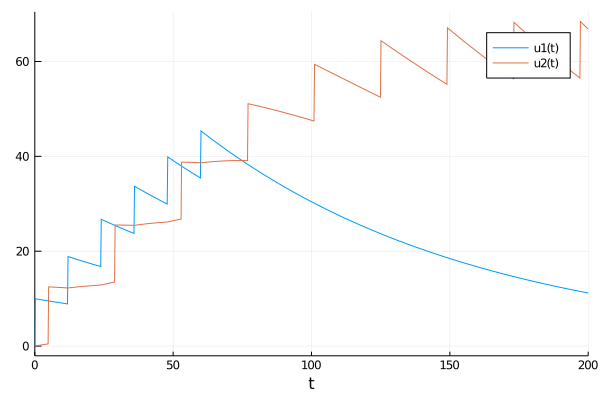

In [10]:
using Plots
plot(sol1)